In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import numpy as np
import pandas as pd
import re
import torch

In [14]:
train_set = pd.read_csv('data/Price_euros_train.csv')
test_set = pd.read_csv('data/Price_euros_test.csv')
sub_set = pd.read_csv('data/Sample_submition.csv')

In [15]:
def delete_null_rows(dataframe):
    cleaned_df = dataframe.dropna()
    print(f"Rows removed: {len(dataframe) - len(cleaned_df)}")
    return cleaned_df
def auto_fill_nulls(dataframe):
    filled_df = dataframe.copy()
    for column in filled_df.columns:
        if filled_df[column].isnull().sum() > 0:  
            if np.issubdtype(filled_df[column].dtype, np.number):
                median_value = filled_df[column].median()
                filled_df[column].fillna(median_value, inplace=True)
                print(f"Filled nulls in numeric column '{column}' with median value: {median_value}")
            else:
                top_3_values = filled_df[column].value_counts().index[:3]
                if len(top_3_values) > 0:  
                    random_choice = np.random.choice(top_3_values)
                    filled_df[column].fillna(random_choice, inplace=True)
                    print(f"Filled nulls in non-numeric column '{column}' with random choice from top 3: {random_choice}")
                else:
                    print(f"Column '{column}' has no valid non-null values to use for filling.")
    return filled_df

In [16]:
def RAM_to_int(df: pd.DataFrame):
    if 'Ram' not in df.columns:
        return df
    df = df.copy()
    df['Ram'] = (
        df['Ram']
        .str.replace('[A-Za-z]', '', regex=True)
        .str.strip()
        .astype(float)
    )
    return df

def kg_to_float(df, column_name):
    if 'Weight' not in df.columns:
        return df
    df = df.copy()
    df[column_name] = (
        df[column_name]
        .str.replace('kg', '', regex=False)
        .str.strip()
        .astype(float)
    )
    return df

def gpu_to_int(df):
    if 'Gpu' not in df.columns:
        return df
    df = df.copy()
    conditions = [
        df['Gpu'].str.contains('intel', case=False, na=False),
        df['Gpu'].str.contains('amd', case=False, na=False),
        df['Gpu'].str.contains('nvidia', case=False, na=False)
    ]

    choices = [1, 2, 3]
    df['Gpu'] = np.select(conditions, choices, default=4).astype(int)
    return df

def cpu_to_freq(df):
    if 'Cpu' not in df.columns:
        return df
    df = df.copy()
    df['Cpu'] = df['Cpu'].str.extract(r'(\d+(?:\.\d+)?)\s*GHz', expand=False)
    df['Cpu'] = pd.to_numeric(df['Cpu'], errors='coerce') 
    return df

def screen_resolution_categorize(df):
    if 'ScreenResolution' not in df.columns:
        return df
    df = df.copy()
    resolution_pattern = r'(\d+)x(\d+)'
    
    resolutions = df['ScreenResolution'].str.extract(resolution_pattern)
    
    resolutions = resolutions.apply(pd.to_numeric, errors='coerce')
    
    df['ScreenResolution_Product'] = resolutions[0] * resolutions[1]
    
    df['ScreenResolution'] = df['ScreenResolution_Product'].apply(
        lambda x: 1 if x < 2073600 else (2 if x == 2073600 else 3)
    )
    
    df.drop('ScreenResolution_Product', axis=1, inplace=True)
    
    return df

def memory_to_features(df):
    if 'Memory' not in df.columns:
        return df
    df = df.copy()
    
    def parse_memory(mem_str):
        parts = mem_str.split('+')
        
        total_hdd = 0
        total_ssd = 0
        total_flash = 0
        
        for part in parts:
            part = part.strip().lower()
            match = re.search(r'(\d+)(tb|gb)', part)
            if not match:
                continue
            size = int(match.group(1))
            unit = match.group(2)
            
            if unit == 'tb':
                size *= 1000
            
            if 'hdd' in part:
                total_hdd += size
            elif 'ssd' in part:
                total_ssd += size
            elif 'flash' in part:
                total_flash += size
        
        return total_hdd, total_ssd, total_flash
    
    parsed = df['Memory'].apply(parse_memory)
    df['Total_HDD_GB'] = parsed.apply(lambda x: x[0])
    df['Total_SSD_GB'] = parsed.apply(lambda x: x[1])
    df['Total_Flash_GB'] = parsed.apply(lambda x: x[2])
    
    df.drop('Memory', axis=1, inplace=True)
    return df

def frequency_encode(df, column_name):
    freq = df[column_name].value_counts()
    df[column_name] = df[column_name].map(freq)
    return df

def frequency_encode_companies_products(df):
    df = df.copy()
    if 'Company' in df.columns:
        df = frequency_encode(df, 'Company')
    if 'Product' in df.columns:
        df = frequency_encode(df, 'Product')
    if 'OpSys' in df.columns:
        df = frequency_encode(df, 'OpSys')
    return df

In [33]:
pipeline = Pipeline([
    ('ram_to_int', FunctionTransformer(RAM_to_int, validate=False)),
    ('weight_to_float', FunctionTransformer(lambda df: kg_to_float(df, 'Weight'), validate=False)),
    ('gpu_to_int', FunctionTransformer(gpu_to_int, validate=False)),
    ('cpu_to_freq', FunctionTransformer(cpu_to_freq, validate=False)),
    ('screen_resolution', FunctionTransformer(screen_resolution_categorize, validate=False)),
    ('memory_to_features', FunctionTransformer(memory_to_features, validate=False)),
    ('freq_encode', FunctionTransformer(frequency_encode_companies_products, validate=False))
    ])

In [34]:
from sklearn.model_selection import train_test_split

def get_data():
    train_set = pd.read_csv('data/Price_euros_train.csv')
    test_set = pd.read_csv('data/Price_euros_test.csv')

    # Preprocess (fill nulls and drop irrelevant columns)
    train_set = auto_fill_nulls(train_set).drop(columns=['laptop_ID', 'TypeName'])
    test_set = auto_fill_nulls(test_set).drop(columns=['laptop_ID', 'TypeName'])

    # Split into features and target
    X = train_set.drop('Price_euros', axis=1)
    y = train_set['Price_euros']

    # Train-test split (on training data!)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit-transform only on training set
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    X_val = pipeline.transform(test_set)

    return X_train, X_test, y_train, y_test, X_val


X_train, X_test, y_train, y_test, X_val = get_data()

Filled nulls in non-numeric column 'ScreenResolution' with random choice from top 3: IPS Panel Full HD 1920x1080
Filled nulls in non-numeric column 'OpSys' with random choice from top 3: Linux
Filled nulls in non-numeric column 'Weight' with random choice from top 3: 2.4kg
Filled nulls in non-numeric column 'ScreenResolution' with random choice from top 3: 1366x768
Filled nulls in non-numeric column 'OpSys' with random choice from top 3: Windows 7
Filled nulls in non-numeric column 'Weight' with random choice from top 3: 2.3kg


C:\Users\1TB\AppData\Local\Temp\ipykernel_16592\618136128.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filled_df[column].fillna(random_choice, inplace=True)
C:\Users\1TB\AppData\Local\Temp\ipykernel_16592\618136128.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [35]:
final_feature_names = [
    'Ram', 
    'Weight', 
    'Gpu', 
    'Cpu', 
    'ScreenResolution', 
    'Total_HDD_GB', 
    'Total_SSD_GB', 
    'Total_Flash_GB', 
    'Company', 
    'Product', 'OpSys', "sss"
]
data_df = pd.DataFrame(X_train, columns=final_feature_names)
data_df

,Ram,Weight,Gpu,Cpu,ScreenResolution,Total_HDD_GB,Total_SSD_GB,Total_Flash_GB,Company,Product,OpSys,sss
1001,4.0,2.20,1,1.6,1,500,0,0,108,1,690,NaN
1061,4.0,1.60,1,2.5,1,500,0,0,193,8,690,NaN
730,8.0,1.62,1,2.3,2,1000,0,0,193,1,690,NaN
949,8.0,1.16,1,2.5,2,0,512,0,189,4,690,NaN
292,8.0,1.48,1,2.6,2,0,256,0,189,6,690,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
466,4.0,2.10,1,2.4,2,0,128,0,189,16,690,NaN
121,4.0,2.20,3,2.5,2,1000,0,0,205,4,45,NaN
1044,4.0,2.65,1,1.6,1,1000,0,0,108,1,690,NaN
1095,16.0,1.30,1,2.5,3,0,512,0,205,3,690,NaN


In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import copy
import datetime as dt
import pandas as pd
import numpy as np
     


In [47]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.X =torch.from_numpy(X.to_numpy().astype(np.float32))
        self.y =torch.from_numpy(y.to_numpy().astype(np.float32))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])
     
data = MyDataset(X_train, y_train)

In [105]:
import torch.nn as nn

ReLU = nn.ReLU()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(12, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc3(x)
        return x.view(-1)
    

net = Net()

In [106]:
class Trainer():
    """
    Parameters:
        dataset: класс, хранящий данные
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество бачей,
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        optim: оптимизатор
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """

    # это классический конструктор класса, он учитывает много различных
    # параметров, часть из которых задаётся по умолчанию
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-3,
                epoch_amount=10, batch_size=12,
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10,
                optim=torch.optim.Adam,
                scheduler=None, permutate=True):

        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    # метод используется для предсказания значения, выбирает лучшую модель
    # из ранее обученных
    def predict(self, X):
        return self.best_model(X)

    # большой метод для тренировки
    # вообще говоря, его можно было разбить ещё на один метод, описывающий
    # тренировку одно отдельной эпоих
    def fit(self, X_train, X_test, y_train, y_test):

        Net = self.start_model # берём исходную модель

        device = torch.device(self.device)

        Net.to(device) # переносим модель на видеокарту

        # задаём оптимизатор
        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        # расписание изменения (уменьшения) скорости изменения и его шаг
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        # создаём из данных dataset и загрузчик
        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate)
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
                                     # функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее
                                     # значение функции потерь на валидационной выборке

        # начинаем обучение по эпохам
        for epoch in range(self.epoch_amount):
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train() # переводим сеть в режим обучения
            mean_loss = 0
            batch_n = 0

            # разбиваем данные на признаки и значения
            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break

                # обнуляем градиенты
                optimizer.zero_grad()

                # переносим данные на карточку
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                # предсказываем значения
                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target) # считаем loss
                loss.backward() # считаем градиенты
                optimizer.step() # меняем значения весов

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n # считаем средний loss по батчам
            self.train_loss.append(mean_loss)

            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval() # переводим модель в режим оценки
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            # вводим механимз ранней остановки
            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

In [110]:
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 1000,
    'learning_rate': 0.00001,
    'early_stopping': 25,
    'loss_f': nn.MSELoss(),
    'optim': torch.optim.Adam#torch.optim.SGD,
}

clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

Эпоха: 0 Loss_train: 644798.1411528717, 0:00:00.125973 сек
Loss_val: 2066878.875

Эпоха: 1 Loss_train: 640930.5232263514, 0:00:00.092162 сек
Loss_val: 2060991.125

Эпоха: 2 Loss_train: 637535.2678420608, 0:00:00.095421 сек
Loss_val: 2054933.375

Эпоха: 3 Loss_train: 633837.3933699324, 0:00:00.092591 сек
Loss_val: 2048706.5

Эпоха: 4 Loss_train: 629641.0224873311, 0:00:00.102593 сек
Loss_val: 2042761.875

Эпоха: 5 Loss_train: 626971.4267314189, 0:00:00.085790 сек
Loss_val: 2036662.625

Эпоха: 6 Loss_train: 622082.2536951014, 0:00:00.095098 сек
Loss_val: 2030649.5

Эпоха: 7 Loss_train: 619781.5848817568, 0:00:00.090174 сек
Loss_val: 2024747.5

Эпоха: 8 Loss_train: 615083.4008657094, 0:00:00.102491 сек
Loss_val: 2018815.875

Эпоха: 9 Loss_train: 613312.9121621621, 0:00:00.096043 сек
Loss_val: 2013190.125

Эпоха: 10 Loss_train: 608663.0942778717, 0:00:00.116574 сек
Loss_val: 2007224.375

Эпоха: 11 Loss_train: 605727.3793285473, 0:00:00.099255 сек
Loss_val: 2001598.375

Эпоха: 12 Loss_train

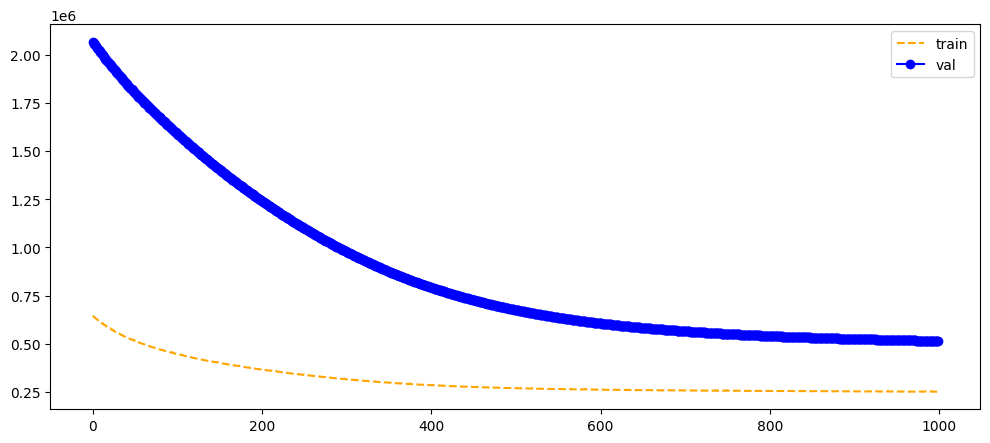

In [111]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(clf.train_loss, clf.val_loss)

In [118]:
# Make sure model is in eval mode
clf.best_model.eval()

# Prepare input
X_val_np = X_val.to_numpy().astype(np.float32)
X_val_tensor = torch.from_numpy(X_val_np).to(clf.device)

# Get predictions
with torch.no_grad():
    y_pred = clf.predict(X_val_tensor).view(-1).cpu().numpy()


In [119]:
expected_length = 195
actual_length = len(y_pred)

if actual_length != expected_length:
    raise ValueError(f"Expected {expected_length} predictions, but got {actual_length}.")

index_values = np.arange(expected_length)

submission_df = pd.DataFrame({
    'index': index_values,
    'Price_euros': y_pred
})

print(submission_df.head())
print(submission_df.tail())

submission_df.to_csv('Submission.csv', index=False)
print("✅ Submission file 'Submission.csv' has been created successfully.")


   index  Price_euros
0      0   444.872345
1      1  3071.000244
2      2   908.386292
3      3  1248.110229
4      4   497.557648
     index  Price_euros
190    190   315.126160
191    191   462.424072
192    192   913.257935
193    193  1690.527710
194    194   864.930664
✅ Submission file 'Submission.csv' has been created successfully.
